In [1]:
#!pip install tweepy
#!pip install environs
#!pip install TextBlob
#!python -m nltk.downloader all
#!pip install demoji
#!pip install wordcloud

![ex_screenshot](./img/1.jpg)
![ex_screenshot](./img/2.jpg)

In [2]:
#!pip install tweepy
from tweepy import API 
from tweepy import Cursor
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv

#pip install environs
from os import environ
load_dotenv()
import json



### Utility Functions
from IPython.display import display, HTML
import pandas as pd
import sqlite3
from sqlite3 import Error
import os



#clean
import re
#centi
#pip install TextBlob
from textblob import TextBlob
#tokenize
import nltk
#!python -m nltk.downloader all
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords
#remove duplicated words
from itertools import groupby
#emoji to txt : pip install demoji
import demoji 

from PIL import Image
import matplotlib.pyplot as plt
#!pip install wordcloud
from wordcloud import WordCloud

### EXTRACT TWEETS WITH THE KEYWORDS AS JSON FILES






![ex_screenshot](./img/3.jpg)

### 4 classes for the twitter

In [3]:
# # # # TWITTER CLIENT # # # #
class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = Authenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth,wait_on_rate_limit=True)
        self.twitter_user = twitter_user
    def get_user_timeline_tweets(self, num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets

    def get_friend_list(self, num_friends):
        friend_list = []
        for friend in Cursor(self.twitter_client.friends, id=self.twitter_user).items(num_friends):
            friend_list.append(friend)
        return friend_list

    def get_home_timeline_tweets(self, num_tweets):
        home_timeline_tweets = []
        for tweet in Cursor(self.twitter_client.home_timeline, id=self.twitter_user).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets

In [4]:
class TwitterStreamer():
    """
    Class for streaming and processing live tweets.
    """
    def __init__(self):
        self.Authenticator = Authenticator()    
    def stream_tweets(self, hash_tag_list):
        listener = TwitterListener()
        auth = self.Authenticator.authenticate_twitter_app() 
        stream = Stream(auth, listener)
        stream.filter(track=hash_tag_list)

In [5]:
class TwitterListener(StreamListener):
    def __init__(self):
        super(StreamListener, self).__init__()
        self.save_file = open('./twt_json/tweets10.json','w')#new_json file
        self.tweets = []
    def on_data(self, tweet):
        try:
            self.tweets.append(json.loads(tweet))
            self.save_file.write(str(tweet))
        except BaseException as e:
            print("Error on_data %s" % str(e))
        return True
    def on_error(self, status):
        if status == 420:
            # Returning False on_data method in case rate limit occurs.
            return False
        print(status)

### Set your twitter Authenticator in the .env file
### "twitter_consumer_key, twitter_consumer_secret, twitter_access_token, twitter_access_secret"

In [6]:
class Authenticator():
    def __init__(self):
        self.CONSUMER_KEY = environ.get('twitter_consumer_key')
        self.CONSUMER_SECRET =environ.get('twitter_consumer_secret')
        self.ACCESS_TOKEN_KEY = environ.get('twitter_access_token')
        self.ACCESS_TOKEN_SECRET = environ.get('twitter_access_secret')
    def authenticate_twitter_app(self):
        auth = OAuthHandler(self.CONSUMER_KEY, self.CONSUMER_SECRET)
        auth.set_access_token(self.ACCESS_TOKEN_KEY, self.ACCESS_TOKEN_SECRET)
        return auth

    


### Json -> extract and modify -> insert into DB

![ex_screenshot](./img/4.jpg)
![ex_screenshot](./img/5.jpg)

### CLASS about DateBase

In [7]:
class DB():
    
    def __init__(self,DB_Name):

        self.tweets_database_filename = DB_Name
        
    def create_connection(self,delete_db=False):

        if delete_db and os.path.exists(self.tweets_database_filename):
            os.remove(self.tweets_database_filename)

        self.conn = None
        try:
            self.conn = sqlite3.connect(self.tweets_database_filename)
            self.conn.execute("PRAGMA foreign_keys = 1")
        except Error as e:
            print(e)

        return self.conn

    def create_table(self,conn, create_table_sql, drop_table_name=None):
    
        if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
            try:
                c = conn.cursor()
                c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
            except Error as e:
                print(e)

        try:
            c = conn.cursor()
            c.execute(create_table_sql)
        except Error as e:
            print(e)
            
    def execute_sql_statement(self, conn ,sql_statement):
        cur = conn.cursor()
        cur.execute(sql_statement)
        rows = cur.fetchall()

        return rows
    
    def execute_many_sql_statement(self, conn,sql_statement,arr_inser_tuples):
        cur = conn.cursor()
        cur.executemany(sql_statement, arr_inser_tuples)
        rows = cur.fetchall()

        return rows   

### CLASS MANIPULATE
#### Json -> Data maipulate -> tuple  List

In [8]:
class Manipulate():
    
    
    def __init__(self, Json_data):
        self.Json_data = Json_data



        
    def JsonToList(self):
        My_list=[]
        Month={'Dec':'12','Jan':1,'Feb':'2','Mar':'3','Apr':'4', 'May':'5', 'Jun':'6', 'Jul':'7', 'Aug':'8', 'Sep':'9', 'Oct':'10', 'Nov':'11'}
        for json in self.Json_data:
            date=json['created_at'].split(" ")
            my_T_DATE = date[5]+'-'+Month[date[1]]+'-'+date[2]+' '+date[3]
            my_tuple = (json['id'], my_T_DATE, json['user']['id'],json['text'],json['user']['followers_count'],json['retweet_count'],json['favorite_count'],json['lang'])
            My_list.append(my_tuple)
        return My_list
    
    def JsonToList_Processed(self):
        My_list_Processed=[]
        emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
        for json in self.Json_data:

            if(json['lang']=='en'):
                json['text'] = re.sub('@[A-Za-z0–9]+', '', json['text']) #Removing @mentions
                json['text'] = re.sub('#', '', json['text']) # Removing '#' hash tag
                json['text'] = re.sub('RT[\s]+', '', json['text']) # Removing RT
                json['text'] = re.sub('https?:\/\/\S+', '', json['text']) # Removing hyperlink
                json['text']=emoji_pattern.sub(r'', json['text'])
                json['text'] = " ".join([k for k,v in groupby(json['text'].split())])#remove duplicated words
                #extract sentiment and subjectivity values from the text and put it into the DB
                subjectivity=TextBlob(json['text']).sentiment.subjectivity
                polarity=TextBlob(json['text']).sentiment.polarity
                my_tuple=(json['id'],json['text'],subjectivity,polarity)
                My_list_Processed.append(my_tuple)
        return My_list_Processed
                

### 'MAIN' FOR GATHERING TWEETS
### in realtime with the KEY WORKDS

In [51]:
# get json file from twiter (streeming)
# if __name__ == '__main__':
#     Authenticate using config.py and connect to Twitter Streaming API.
#     hash_tag_list = ["suiside", "depressed","depress","depression", "mentalillness"]
#     twitter_streamer = TwitterStreamer()
#     twitter_streamer.stream_tweets( hash_tag_list)

### 'MAIN' FOR INSERTING TWEETS AND MOD_TWEETS
### into DB

In [9]:
if __name__ == '__main__':


    json_data = []
    twt_json=['tweets.json','tweets1.json','tweets2.json','tweets3.json','tweets4.json','tweets5.json','tweets6.json','tweets7.json','tweets8.json','tweets9.json']
    for js in twt_json:
        with open('./twt_json/'+js, 'r') as f:
            for line in f:
                try:
                    json_data.append(json.loads(line))
                except json.decoder.JSONDecodeError:
                    pass # skip this line 


    #create DB object
    my_db=DB('tweet777.db')
    
    #make a connection
    conn=my_db.create_connection()
    
    #Create TweetDB
    create_table_sql="CREATE TABLE TweetDB (Tweet_ID Integer not null primary key, T_DATE datetime, User_id Integer not null, tw_text text not null, followers_count integer, retweet_count Integer, favorite_count Integer, language text);"
    my_db.create_table(conn, create_table_sql, drop_table_name='TweetDB')
    
    #Insert the Query
    aa=Manipulate(json_data)
    arr_inser_tuples=aa.JsonToList()
    insert_sql_query="""INSERT INTO TweetDB (Tweet_ID, T_DATE, User_id , tw_text , followers_count , retweet_count , favorite_count, language)
             values (?, ?, ?, ?, ?, ?, ?,?);"""
    my_db.execute_many_sql_statement(conn,insert_sql_query,arr_inser_tuples)

    #Create analysis_DB
    create_table_sql_Sub_Pol="CREATE TABLE Sub_Pol (Tweet_ID Integer not null primary key, Pruned_text text, subjectivity Integer, polarity Integer);"
    my_db.create_table(conn, create_table_sql_Sub_Pol, drop_table_name='Sub_Pol')    
    #Process the txt and get list for pruned_txt+centimental anlysis 
    arr_inser_tuples_Sub_Pol=aa.JsonToList_Processed()
    insert_sql_query_Sub_Pol="""INSERT INTO Sub_Pol (Tweet_ID, Pruned_text, subjectivity , polarity )
             values (?, ?, ?, ?);"""    
    my_db.execute_many_sql_statement(conn,insert_sql_query_Sub_Pol,arr_inser_tuples_Sub_Pol)

    


In [10]:
print("the number of Json files(tweets)",len(json_data))

the number of Json files(tweets) 8389


### TWEET DB (DB for Originanl TWEETS)

In [11]:
df = pd.read_sql_query("""SELECT * FROM TweetDB """, conn)
df

,Tweet_ID,T_DATE,User_id,tw_text,followers_count,retweet_count,favorite_count,language
0,1338356506530615296,2020-12-14 05:33:51,1250808191883120640,RT @vmingaIIery: how to make your twitter both...,580,0,0,en
1,1338356508778668035,2020-12-14 05:33:51,1279775309106036736,thinking about jeno blue hair https://t.co/wPk...,1825,0,0,en
2,1338356510200483843,2020-12-14 05:33:52,1299690503177338881,Bayangin jay blue hair,1325,0,0,in
3,1338356512419246081,2020-12-14 05:33:52,1313952185353269248,imagine if the dteam got matching hair colors....,1590,0,0,en
4,1338356513539194880,2020-12-14 05:33:52,1119980300694622208,MY GOT DAMN HAIR IS GREEN NOT BLUE,50,0,0,en
...,...,...,...,...,...,...,...,...
8384,1339464074673983488,2020-12-17 06:54:56,900270579038785536,RT @KissTV4: parents can spot fake friends but...,1080,0,0,en
8385,1339464077479796739,2020-12-17 06:54:56,1066331987118411782,RT @KissTV4: parents can spot fake friends but...,2422,0,0,en
8386,1339464077572272129,2020-12-17 06:54:56,451567891,RT @KissTV4: parents can spot fake friends but...,160,0,0,en
8387,1339464077735829506,2020-12-17 06:54:56,1289350544545456128,"Hoje em dia não sinto mais nada pra escrever, ...",31,0,0,pt


### TWEET DB (DB for Pruned_text, subjectivity, and polarity TWEETS)

In [12]:
df_ = pd.read_sql_query("""SELECT * FROM Sub_Pol """, conn)
df_

,Tweet_ID,Pruned_text,subjectivity,polarity
0,1338356506530615296,: how to make your twitter both blue and pink ...,0.200000,-0.050000
1,1338356508778668035,thinking about jeno blue hair,0.100000,0.000000
2,1338356512419246081,imagine if the dteam got matching hair colors....,0.133333,-0.066667
3,1338356513539194880,MY GOT DAMN HAIR IS GREEN NOT BLUE,0.200000,-0.100000
4,1338356514113765377,Sushant was an intellectual. He was not depres...,0.400000,0.300000
...,...,...,...,...
6642,1339464066427969538,"I'm more depressed than I was in 2016, and tha...",0.655556,-0.266667
6643,1339464074673983488,4: parents can spot fake friends but can't eve...,1.000000,-0.500000
6644,1339464077479796739,4: parents can spot fake friends but can't eve...,1.000000,-0.500000
6645,1339464077572272129,4: parents can spot fake friends but can't eve...,1.000000,-0.500000


### HOW TO MAKE THE DEPRESSION_SCORE MODEL

#### 1. TOKENIZE the refined TEXT with the KEY words that polarity value is lower than -0.5
(tokenized words related to bad emotion)

#### 2. TOKENIZE the refined TEXT with the KEY words that polarity value is 0
(tokenized words related to neutral emotion)

#### 3. The Result from 1st step - Result from 2nd step

#### 4. GIVE penalty to stop words from the result of step 4.

#### 5. Delete KEY WORDS and Ad materials from the result of step 3.


![ex_screenshot](./img/6.jpg)
![ex_screenshot](./img/7.jpg)

### We can see as the subjectivity values going up, the variance of polarity is going up

In [13]:
df_uni = pd.read_sql_query("""SELECT polarity,subjectivity ,followers_count,t.T_DATE FROM Sub_Pol s, TweetDB t where s.Tweet_ID=t.Tweet_ID and followers_count <100 """, conn)

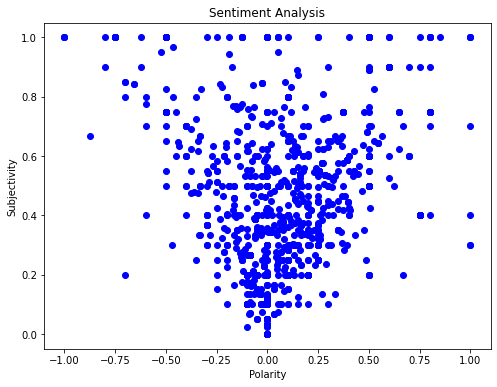

In [14]:
#high subjectivity high var() for the polarity
plt.figure(figsize=(8,6)) 
for i in range(0, df_uni.shape[0]):
      plt.scatter(df_uni['polarity'][i],df_uni['subjectivity'][i], color='Blue')
plt.title('Sentiment Analysis') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.show()

## 1. TOKENIZE the refined TEXT with the KEY words that polarity value is lower than -0.5



In [15]:
df_SUB_POL = pd.read_sql_query("""SELECT * FROM Sub_Pol where polarity < -0.5""", conn)
Pruned_TXT_Neg6=df_SUB_POL['Pruned_text']
fdist=FreqDist()
#pst=PorterStemmer()
#lst=LancasterStemmer()
for ele in Pruned_TXT_Neg6:
    ele_tok=word_tokenize(ele)
    for tok_word in ele_tok:
        fdist[tok_word.lower()]+=1
df_SUB_POL

,Tweet_ID,Pruned_text,subjectivity,polarity
0,1338356540508614658,"And if they didn't get the vaccine, they would...",0.666667,-0.700000
1,1338356664802697219,: I was too sad &amp; depressed this yearI wil...,1.000000,-0.625000
2,1338356849599397889,It won’t be a bad day for two senators at all!...,0.666667,-0.875000
3,1338460260835725314,Mean while in Google Hq INTRUDER ALEBLUE FOX I...,0.843750,-0.656250
4,1338460341768863745,We now have hate and senate grid lock because ...,0.900000,-0.800000
...,...,...,...,...
97,1339462675068297217,It’s so sad how much I fucking hate you and ho...,0.950000,-0.650000
98,1339462946867580929,"@_MightyB: I tell anyone idc, idc. Sex is lite...",0.800000,-0.600000
99,1339463034226565121,: [+18 Release TRIBUTE] Ghost queen is here to...,1.000000,-0.750000
100,1339463426981150720,7: Hold each day close. Never be afraid to fai...,0.500000,-0.533333


In [16]:
fdist
fdist_top_10=fdist.most_common(10)
fdist_top_10


[('i', 71),
 (':', 52),
 ('.', 41),
 ('to', 41),
 ('’', 38),
 (',', 37),
 ('depression', 37),
 ('and', 36),
 ('a', 34),
 ('it', 30)]

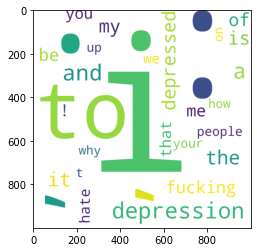

In [17]:
wc_pol_Np5 = WordCloud(background_color="white",width=1000,height=1000, max_words=30,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(fdist)
plt.imshow(wc_pol_Np5)


## 2. TOKENIZE the refined TEXT with the KEY words that polarity value is 0



In [18]:
df_SUB_POL_midP = pd.read_sql_query("""SELECT * FROM Sub_Pol where polarity = 0 """, conn)
Pruned_TXT_mid=df_SUB_POL_midP['Pruned_text']
fdist_mid=FreqDist()
for ele in Pruned_TXT_mid:
    ele_tok=word_tokenize(ele)
    for tok_word in ele_tok:
        fdist_mid[tok_word.lower()]+=1


In [19]:
df_SUB_POL_midP

,Tweet_ID,Pruned_text,subjectivity,polarity
0,1338356508778668035,thinking about jeno blue hair,0.100,0
1,1338356514344611846,@666tone: blue jeans,0.100,0
2,1338356516613627906,: Total tweets for Rahul Vaidya with all tagli...,0.425,0
3,1338356523097985024,__: Finally ID unlock ho gai !!! Yeh blue chid...,0.550,0
4,1338356526088671232,delfisdoodles: blue gfs commission for !!,0.100,0
...,...,...,...,...
2304,1339464030763683842,Currently: shaking my ass till I shake all the...,0.400,0
2305,1339464036442923009,_tu: I want whatever functional depression Tay...,0.000,0
2306,1339464052045594625,I mentioned it on the episode we recorded for ...,0.000,0
2307,1339464061378064385,I can’t decide whether I would sleep forever o...,0.000,0


In [20]:
fdist_mid
fdist_mid_top_10=fdist_mid.most_common(10)
fdist_mid_top_10

[(':', 1256),
 ('blue', 949),
 ('i', 787),
 ('the', 785),
 (',', 762),
 ('.', 726),
 ('to', 510),
 ('of', 491),
 ('and', 491),
 ('depression', 431)]

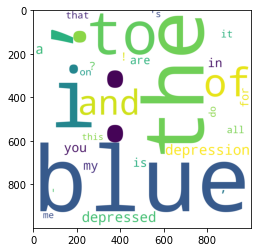

In [21]:
wc_fdist_mid = WordCloud(background_color="white",width=1000,height=1000, max_words=30,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(fdist_mid)
plt.imshow(wc_fdist_mid)


## 3. (the Result from 1st step) - (the Result from 2nd step)


In [22]:
sum=0
sum_mid=0
for ele in fdist:
    #print(fdist[ele])
    sum=sum+fdist[ele]
print('The number of tok_1st',sum)

for ele_ in fdist_mid:
    #print(fdist_mid[ele_])
    sum_mid=sum_mid+fdist_mid[ele_]
print('The number of tok_2nd',sum_mid)

The number of tok_1st 2004
The number of tok_2nd 33345


In [23]:
for ele in fdist:
    fdist[ele]=fdist[ele]/sum

In [24]:
for ele_ in fdist_mid:
    fdist_mid[ele_]=fdist_mid[ele_]/sum_mid

In [25]:
for ele in fdist_mid:
    if(fdist[ele]!=0):
        fdist[ele]=fdist[ele]-fdist_mid[ele]

In [26]:
fdist.most_common(30)

[('i', 0.01182740232535379),
 ('fucking', 0.010948054408501934),
 ('be', 0.009137864621633924),
 ('it', 0.008402358575696111),
 ('hate', 0.007954042432454029),
 ('’', 0.006186547283301145),
 ('depression', 0.005537597768924587),
 ('me', 0.005290857780615108),
 ('to', 0.005164434962733102),
 ('a', 0.005030245402133206),
 ('bad', 0.00499001996007984),
 ('up', 0.004728464797799812),
 ('[', 0.004660135419668984),
 (']', 0.004660135419668984),
 ('why', 0.004499368334855256),
 ('people', 0.004488548768410099),
 ('we', 0.0044860795727483405),
 ('how', 0.004409399823834113),
 ('is', 0.004206297257037882),
 ('here', 0.0040603453461947004),
 ('worst', 0.003493013972055888),
 ('+18', 0.003493013972055888),
 ('tribute', 0.003493013972055888),
 ('queen', 0.003493013972055888),
 ('________', 0.003493013972055888),
 ('nsfwdiives', 0.003493013972055888),
 ('nsfw…', 0.003493013972055888),
 ('sad', 0.0034330349647084596),
 ('release', 0.0034330349647084596),
 ('ghost', 0.0034330349647084596)]


## 4. GIVE penalty to stop words from the result of step 4.


In [27]:
#gives penalty to the stop words
for ele in fdist:
    #print(fdist[ele])
    if ele in stopwords.words('english'):
        fdist[ele]=fdist[ele]/10


In [28]:
fdist.most_common(10)

[('fucking', 0.010948054408501934),
 ('hate', 0.007954042432454029),
 ('’', 0.006186547283301145),
 ('depression', 0.005537597768924587),
 ('bad', 0.00499001996007984),
 ('[', 0.004660135419668984),
 (']', 0.004660135419668984),
 ('people', 0.004488548768410099),
 ('worst', 0.003493013972055888),
 ('+18', 0.003493013972055888)]


## 5. Delete KEY WORDS and Ad materials from the result of step 3.

In [29]:
#delete the KEY word(depression) as well as ad materials
fdist.pop('+18')
fdist.pop('’')
fdist.pop('[')
fdist.pop(']')
fdist.pop('________')
fdist.pop('❤️')
fdist.pop('nsfwdiives')
fdist.pop('nsfw…')
fdist.pop('(')
fdist.pop('depression')


0.005537597768924587

## SCORING TABLE and WORD CLOUD for the result

In [30]:
fdist.most_common(20)

[('fucking', 0.010948054408501934),
 ('hate', 0.007954042432454029),
 ('bad', 0.00499001996007984),
 ('people', 0.004488548768410099),
 ('worst', 0.003493013972055888),
 ('tribute', 0.003493013972055888),
 ('queen', 0.003493013972055888),
 ('sad', 0.0034330349647084596),
 ('release', 0.0034330349647084596),
 ('ghost', 0.0034330349647084596),
 ('heal', 0.0034330349647084596),
 ('background', 0.0034030454610347455),
 ('!', 0.0025918024499808293),
 ('know', 0.0025825092953993046),
 ('bonds', 0.00249500998003992),
 ('day', 0.0024242114062473347),
 ('w', 0.0023750519653450634),
 ('god', 0.0022550939506502067),
 ('things', 0.0020451674249342073),
 ('schizophrenia', 0.001996007984031936)]

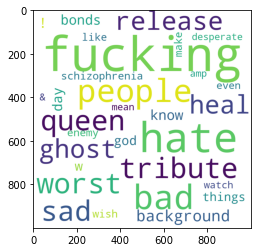

In [31]:
wc = WordCloud(background_color="white",width=1000,height=1000, max_words=30,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(fdist)
plt.imshow(wc)

![ex_screenshot](./img/8.jpg)

## CHECK the DP_score with one of the tweet in the DB

In [32]:
example = pd.read_sql_query("""SELECT * FROM Sub_Pol s join TweetDB t on s.Tweet_ID = t.Tweet_ID where s.Tweet_ID=1339462675068297217 """, conn)
example['Pruned_text']
example_txt=example['tw_text']



In [33]:
score=0
for ele in str(example_txt).split(' '):
    score=score+fdist[ele]*1000

print(str(example_txt))
print("depression score:",score)

0    It’s so sad how much I fucking hate you and ho...
Name: tw_text, dtype: object
depression score: 23.683743623863382


## CHECK the DP_score with tweets from one's twitter account.


In [34]:
#https://twitter.com/WoosungLee8
twitter_client = TwitterClient('WoosungLee8')
tweet_normal=twitter_client.get_user_timeline_tweets(2)[1]
tweet_bad=twitter_client.get_user_timeline_tweets(2)[0]
normal_tweet=tweet_normal._json['text']
depressed_tweet=tweet_bad._json['text']
print(normal_tweet)
print(depressed_tweet)

Hi! CLASS. I AM WOOSUNG LEE! NICE TO MEET YOU
I really hate people who are bad. They are the worst.


In [35]:
score=0
for ele in str(normal_tweet).split(' '):
    score=score+fdist[ele]*1000
print(normal_tweet)
print('depression_score:',score)

Hi! CLASS. I AM WOOSUNG LEE! NICE TO MEET YOU
depression_score: 0


In [36]:
score=0
for ele in str(depressed_tweet).split(' '):
    score=score+fdist[ele]*1000
print(depressed_tweet)
print('depression_score:',score)

I really hate people who are bad. They are the worst.
depression_score: 10.760651436667825
